In [1]:
%load_ext autoreload
import os
import json
from warnings import warn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans

from postamats.utils.connections import DB, PATH_TO_ROOT
from postamats.utils import prepare_data, helpers
from postamats.global_constants import RAW_METRO_NAME, MANDATORY_COLS, OBJECT_TYPE_COL, \
    OBJECT_ID_METRO_COL, ADDRESS_COL, DISTRICT_COL, LATITUDE_COL, LONGITUDE_COL, ADM_AREA_COL,\
        OBJECT_ID_COL, ALL_METRO_NAME

pd.set_option('display.max_columns', None)

In [2]:
CONFIG_PATH = os.path.join(PATH_TO_ROOT, 'db_config.json')

In [3]:
from typing import Iterable, List, Optional, Tuple

def unify_names(name: str) -> str:
    """Простая обработка названий для станций метро и линий

    Args:
        name (str): _description_

    Returns:
        str: _description_
    """
    if not isinstance(name, str):
        warn(f'{name} not str')
        return name
    name = name.replace('ё','е')
    name = name.lower()
    name = ' '.join(name.split())
    return name


def check_nf_ex_pass(metro_entr: pd.DataFrame, metro_pass: pd.DataFrame) -> Tuple[set, set]:
    """Аналитическая функция
    Возвращает, для каких входов не нашлось данных о пассажиропотоке их станций метро и
     для каких станций метро не нашлось данных о входах

    Args:
        metro_entr (pd.DataFrame): _description_
        metro_pass (pd.DataFrame): _description_

    Returns:
        Tuple[set, set]: _description_
    """
    metro_entr = metro_entr.copy()
    metro_pass = metro_pass.copy()
    metro_entr['Station'] = metro_entr['Station'].apply(unify_names)
    metro_pass['Station'] = metro_pass['Station'].apply(unify_names)

    names_pass = set(metro_pass['Station'])
    names_entr = set(metro_entr['Station'])

    nf_pass = names_entr.difference(names_pass)
    ex_pass = names_pass.difference(names_entr)
    print(f'Для {len(nf_pass)} входов не нашлось станций (пассажиропотока):', nf_pass)
    print(f'\nДля {len(ex_pass)} станций не нашлись входы (координаты для пассажиропотока):', ex_pass)
    return nf_pass, ex_pass


def extract_entrance_number(entrance_name: str, entrances_substr: List[str]=None) -> int:
    """Извлекает из названия выхода его номер

    Args:
        entrance_name (str): _description_
        entrances_substr (List[str], optional): _description_. Defaults to None.

    Returns:
        int: _description_
    """
    if entrances_substr is None:
        entrances_substr = ['вход-выход', 'вход', 'выход']
    name = entrance_name.lower()\
        .replace(',', ' ').replace(' -', '-').replace('- ', '-').replace(' - ', '-')

    splited = name.split()
    for i, word in enumerate(splited):
        if word in entrances_substr:
            try:
                if splited[i+1][0].isdigit():
                    return splited[i+1]
            except IndexError:
                try:
                    if splited[i-1][0].isdigit():
                        return splited[i-1]
                except IndexError:
                    return np.nan
    return np.nan


def find_min_clusters(m_slice: pd.DataFrame,
                     max_dist=100,
                     latitude_col: str='lat',
                     longitude_col: str='lon') -> List[int]:
    """Находит минимальное количество кластеров, на которые можно разбить
     множество входов в метро так, чтобы максимальное расстояние между
     входами внутри кластера было не больше max_dist

    Args:
        m_slice (pd.DataFrame): _description_
        max_dist (int, optional): _description_. Defaults to 100.

    Returns:
        List[int]: метки кластеров для входов
    """
    n_ent = len(m_slice)
    m_slice_cartesian = helpers.calc_cartesian_coords(m_slice[latitude_col], m_slice[longitude_col])
    if n_ent == 1:
        return [0]
    n_clusts = 1
    for _ in range(n_ent):
        clust = KMeans(n_clusters=n_clusts)
        labels = clust.fit_predict(m_slice_cartesian[['x', 'y']])
        for lbl in labels:
            m_slice_clust = m_slice[labels==lbl].copy()
            clust_cross = m_slice_clust[[latitude_col, longitude_col]]\
                .merge(m_slice_clust[[latitude_col, longitude_col]], how='cross')

            dists = clust_cross.apply(helpers.haversine_vectorized, args=tuple(clust_cross.columns), axis=1)
            if dists.max() <= max_dist:
                return list(labels)
        n_clusts += 1


def get_entrances_clusters(metro: pd.DataFrame,
                           groupby: str,
                           max_dist=100,
                           latitude_col: str='lat',
                           longitude_col: str='lon',
                           cluster_col: str='Cluster') -> pd.DataFrame:
    """ Обогащает датафрейм метро названиями кластеров
         для входов в метро. Кластера получены таким образом, что расстояние
         между входами внутри кластера не превышает max_dist

    Args:
        metro (pd.DataFrame): датафрейм с данными о входах метро и пассажиропотоке
         соответствующих станций
        max_dist (int, optional): _description_. Defaults to 100.

    Returns:
        pd.DataFrame: _description_
    """
    metro = metro.copy()
    all_stations = metro[groupby].unique()
    grouped = metro.groupby(groupby)
    lbls_list = []
    indx_list = []
    for stn in all_stations:
        grp = grouped.get_group(stn)
        indx_list += grp.index.to_list()
        lbls_list += find_min_clusters(grp,
                                       max_dist=max_dist,
                                       latitude_col=latitude_col,
                                       longitude_col=longitude_col)

    metro[cluster_col] = pd.Series(index=indx_list, data=lbls_list)
    return metro

def get_agglomerations_geocenter(metro: pd.DataFrame,
                                colname: str,
                                x_col: str='lon',
                                y_col: str='lat',
                                postfixes: tuple=('_lon', '_lat')
                                ) -> pd.DataFrame:
    """Возвращает широту и долготу для аггломератов метро
     (станций или кластеров входов) по принципу центроида полигона

    Args:
        metro (pd.DataFrame): _description_
        colname (str): по какой колонке нужно посчитать аггломераты

    Returns:
        pd.DataFrame: _description_
    """
    metro = metro.copy()
    metro['list'] = metro[[x_col, y_col]].apply(list, axis=1)
    clust_plgn = metro.groupby(colname)['list'].apply(list)
    clust_center = clust_plgn.apply(helpers.calc_polygon_centroid).apply(pd.Series)
    clust_center.columns = [f'{colname}{postfixes[0]}', f'{colname}{postfixes[1]}']
    metro = metro.merge(clust_center.reset_index())
    metro = metro.drop(columns=['list'])
    return metro


def get_agglomerations_weighted_geocenter(metro: pd.DataFrame,
                                          colname: str,
                                          x_col: str='lon',
                                          y_col: str='lat',
                                          postfixes: tuple=('_lon', '_lat'),
                                          weights: Optional[Iterable]=None) -> pd.DataFrame:
    """Возвращает широту и долготу для аггломератов метро
     (станций или кластеров входов) по принципу центра масс

    Args:
        metro (pd.DataFrame): _description_
        colname (str): по какой колонке нужно посчитать аггломераты

    Returns:
        pd.DataFrame: _description_
    """
    metro = metro.copy()
    metro['weight'] = 1

    if weights is not None:
        metro['weight'] = np.asarray(weights)

    clust_plgn = metro.groupby(colname)[[x_col, y_col, 'weight']].agg(list)
    clust_center = clust_plgn.apply(
        lambda x: helpers.find_center_mass(x[x_col], x[y_col], x['weight']),
        axis=1).apply(pd.Series)
    clust_center = clust_center.iloc[:, :2]
    clust_center.columns = [f'{colname}{postfixes[0]}', f'{colname}{postfixes[1]}']
    metro = metro.merge(clust_center.reset_index())
    metro = metro.drop(columns=['weight'])
    return metro

In [4]:
entr_path = os.path.join(PATH_TO_ROOT, 'data', 'subway', 'entrances')
pass_path = os.path.join(PATH_TO_ROOT, 'data', 'subway', 'passengers')
entr_file = prepare_data.get_filenames_from_dir(entr_path, mandatory_substr='json')[0]
pass_file = prepare_data.get_filenames_from_dir(pass_path, mandatory_substr='json')[0]

print(entr_file)
print(pass_file)

/Users/affernus/PROJECTS/hacks/postomat_optimisation/data/subway/entrances/data-397-2022-10-21.json
/Users/affernus/PROJECTS/hacks/postomat_optimisation/data/subway/passengers/data-115426-2022-10-21.json


In [5]:
metro_entr = pd.read_json(entr_file, encoding='cp1251', typ='frame')
metro_pass = pd.read_json(pass_file, encoding='cp1251', typ='frame')

metro_pass = metro_pass.rename(columns={'NameOfStation': 'Station'})
metro_entr = metro_entr.rename(columns={'Name': 'EntranceName', 'NameOfStation': 'Station'})

metro_entr['Station'] = metro_entr['EntranceName'].apply(lambda x: x.split(',')[0])
metro_entr['EntranceNumber'] = metro_entr['EntranceName'].apply(extract_entrance_number)

zero_pass_cond = (metro_pass['IncomingPassengers']==0)\
        &\
        (metro_pass['OutgoingPassengers']==0)

pass_lower_lim = 1 * 24 * 30 * 3
# меньше 1 человека в день в среднем за день вызывает вопросы к полноте квартальных данных
pass_lim_cond = \
        (metro_pass['IncomingPassengers']>pass_lower_lim)\
        &\
        (metro_pass['OutgoingPassengers']>pass_lower_lim)
display(metro_pass[~pass_lim_cond & ~zero_pass_cond])

metro_pass = metro_pass[pass_lim_cond]
# закрытые сейчас выходы не притягивают население, исключаем их
metro_entr = metro_entr[metro_entr['ObjectStatus'] != 'временно закрыт']

metro_entr['Station'] = metro_entr['Station'].apply(unify_names)
metro_pass['Station'] = metro_pass['Station'].apply(unify_names)
metro_pass['Line'] = metro_pass['Line'].apply(unify_names)
metro_entr['Line'] = metro_entr['Line'].apply(unify_names)

,Station,Line,Year,Quarter,IncomingPassengers,OutgoingPassengers,global_id
1061,Парк Победы,Солнцевская линия,2021,IV квартал,354,327,1508958626


In [6]:
set(metro_pass['Line']).symmetric_difference(metro_entr['Line'])

set()

In [7]:
display(metro_entr)
display(metro_pass)

,ID,EntranceName,OnTerritoryOfMoscow,AdmArea,District,Longitude_WGS84,Latitude_WGS84,VestibuleType,Station,Line,CulturalHeritageSiteStatus,ModeOnEvenDays,ModeOnOddDays,LittleFunctionalBPAAmount,BPAAmount,RepairOfEscalators,ObjectStatus,global_id,geoData,FullFeaturedBPAAmount,EntranceNumber
0,331,"Китай-город, вход-выход 5 в северный вестибюль",да,Центральный административный округ,Басманный район,37.631677,55.757315,подземный,китай-город,калужско-рижская линия,не является объектом культурного наследия,открытие в 05:30:00; закрытие в 01:00:00; перв...,открытие в 05:30:00; закрытие в 01:00:00; перв...,4.0,4.0,[],действует,1773539,"{'coordinates': [37.6316766, 55.7573154], 'typ...",NaN,5
1,327,"Китай-город, вход-выход 4 в северный вестибюль",да,Центральный административный округ,Тверской район,37.631205,55.756855,подземный,китай-город,калужско-рижская линия,не является объектом культурного наследия,открытие в 05:30:00; закрытие в 01:00:00; перв...,открытие в 05:30:00; закрытие в 01:00:00; перв...,4.0,4.0,[],действует,1773540,"{'coordinates': [37.631205, 55.756855], 'type'...",NaN,4
2,330,"Китай-город, вход-выход 6 в северный вестибюль",да,Центральный административный округ,Басманный район,37.631951,55.757236,подземный,китай-город,калужско-рижская линия,не является объектом культурного наследия,открытие в 05:30:00; закрытие в 01:00:00; перв...,открытие в 05:30:00; закрытие в 01:00:00; перв...,4.0,4.0,[],действует,1773541,"{'coordinates': [37.6319506, 55.7572362], 'typ...",NaN,6
3,322,"Китай-город, вход-выход 14 в южный вестибюль",да,Центральный административный округ,Тверской район,37.633082,55.753098,подземный,китай-город,калужско-рижская линия,не является объектом культурного наследия,открытие в 05:30:00; закрытие в 01:00:00; перв...,открытие в 05:30:00; закрытие в 01:00:00; перв...,4.0,4.0,[],действует,1773542,"{'coordinates': [37.633082, 55.753098], 'type'...",NaN,14
4,321,"Китай-город, вход-выход 12 в южный вестибюль",да,Центральный административный округ,Таганский район,37.633559,55.753072,подземный,китай-город,калужско-рижская линия,не является объектом культурного наследия,открытие в 05:30:00; закрытие в 01:00:00; перв...,открытие в 05:30:00; закрытие в 01:00:00; перв...,4.0,4.0,[],действует,1773543,"{'coordinates': [37.633559, 55.753072], 'type'...",NaN,12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1062,1283,"Тверская, вход-выход 2 объединенный вестибюль",да,Центральный административный округ,Тверской район,37.604050,55.765663,подземный,тверская,замоскворецкая линия,не является объектом культурного наследия,открытие в 05:30:00; закрытие в 01:00:00; перв...,открытие в 05:30:00; закрытие в 01:00:00; перв...,2.0,6.0,[],действует,2382343273,"{'coordinates': [37.60405014, 55.7656634300000...",4.0,2
1063,1284,"Тверская, вход-выход 3 объединенный вестибюль",да,Центральный административный округ,Тверской район,37.603986,55.765282,подземный,тверская,замоскворецкая линия,не является объектом культурного наследия,открытие в 05:30:00; закрытие в 01:00:00; перв...,открытие в 05:30:00; закрытие в 01:00:00; перв...,2.0,6.0,[],действует,2382344244,"{'coordinates': [37.60398577, 55.76528236], 't...",4.0,3
1064,1285,"Тверская, вход-выход 5 объединенный вестибюль",да,Центральный административный округ,Тверской район,37.604962,55.765304,подземный,тверская,замоскворецкая линия,не является объектом культурного наследия,открытие в 05:30:00; закрытие в 01:00:00; перв...,открытие в 05:30:00; закрытие в 01:00:00; перв...,2.0,6.0,[],действует,2382344419,"{'coordinates': [37.60496209, 55.76530353], 't...",4.0,5
1065,1286,"Тверская, вход-выход 7 объединенный вестибюль",да,Центральный административный округ,Тверской район,37.606255,55.764850,подземный,тверская,замоскворецкая линия,не является объектом культурного наследия,открытие в 05:30:00; закрытие в 01:00:00; перв...,открытие в 05:30:00; закрытие в 01:00:00; перв...,2.0,6.0,[],действует,2382344544,"{'coordinates': [37.60625492, 55.76484987], 't...",4.0,

,Station,Line,Year,Quarter,IncomingPassengers,OutgoingPassengers,global_id
0,митино,арбатско-покровская линия,2021,I квартал,1913498,1829031,1138975996
1,волоколамская,арбатско-покровская линия,2021,I квартал,1236714,1222309,1138975997
2,строгино,арбатско-покровская линия,2021,I квартал,1938816,1903731,1138975999
3,крылатское,арбатско-покровская линия,2021,I квартал,1849616,1818208,1138976000
4,площадь революции,арбатско-покровская линия,2021,I квартал,2324687,2319343,1138976008
...,...,...,...,...,...,...,...
1677,лесопарковая,бутовская линия легкого метро,2022,III квартал,634458,602966,2389510466
1678,авиамоторная,калининская линия,2022,III квартал,3400258,3570615,2389510472
1679,киевская,кольцевая линия,2022,III квартал,3152625,3070193,2389510476
1680,ботанический сад,московское центральное кольцо,2022,III квартал,1002370,1225726,2389510486


In [8]:
nf_pass, ex_pass = check_nf_ex_pass(metro_entr, metro_pass)

Для 5 входов не нашлось станций (пассажиропотока): {'румянцево вход-выход 2 в северный вестибюль', 'румянцево вход-выход 1 в южный вестибюль', 'арбатская (арбатско-покровская линия)', 'электрозаводская вход-выход в вестибюль (нкр)', 'тверская'}

Для 3 станций не нашлись входы (координаты для пассажиропотока): {'румянцево', 'улица старокачаловская', 'каширская'}


In [9]:
metro_pass.loc[
    (metro_pass['Station']=='арбатская') & (metro_pass['Line']=='Арбатско-Покровская линия'),
    'Station'
    ] = 'арбатская (арбатско-покровская линия)'

In [10]:
nf_pass, ex_pass = check_nf_ex_pass(metro_entr, metro_pass)

Для 5 входов не нашлось станций (пассажиропотока): {'румянцево вход-выход 2 в северный вестибюль', 'румянцево вход-выход 1 в южный вестибюль', 'арбатская (арбатско-покровская линия)', 'электрозаводская вход-выход в вестибюль (нкр)', 'тверская'}

Для 3 станций не нашлись входы (координаты для пассажиропотока): {'румянцево', 'улица старокачаловская', 'каширская'}


In [11]:
nf_pass_cond = metro_entr['Station'].isin(nf_pass)
metro_entr.loc[nf_pass_cond, 'Station'] = metro_entr.loc[nf_pass_cond, 'Station'].apply(lambda x: x.split()[0])

In [12]:
nf_pass, ex_pass = check_nf_ex_pass(metro_entr, metro_pass)

Для 1 входов не нашлось станций (пассажиропотока): {'тверская'}

Для 2 станций не нашлись входы (координаты для пассажиропотока): {'улица старокачаловская', 'каширская'}


In [13]:
metro_pass[metro_pass['Station'].isin(ex_pass)]

,Station,Line,Year,Quarter,IncomingPassengers,OutgoingPassengers,global_id
230,каширская,замоскворецкая линия,2021,I квартал,1571003,1585223,1139049541
274,каширская,замоскворецкая линия,2021,II квартал,1641960,1666429,1139049606
761,каширская,замоскворецкая линия,2021,III квартал,1663426,1703283,1266159605
851,улица старокачаловская,бутовская линия легкого метро,2021,IV квартал,1520737,1471075,1508957906
858,каширская,замоскворецкая линия,2021,IV квартал,2177394,2231913,1508957913
1141,каширская,замоскворецкая линия,2022,I квартал,2025613,2074945,2363398738
1427,каширская,замоскворецкая линия,2022,II квартал,2247467,2286992,2375902292


In [14]:
metro_entr[metro_entr['Station'].isin(nf_pass)]

,ID,EntranceName,OnTerritoryOfMoscow,AdmArea,District,Longitude_WGS84,Latitude_WGS84,VestibuleType,Station,Line,CulturalHeritageSiteStatus,ModeOnEvenDays,ModeOnOddDays,LittleFunctionalBPAAmount,BPAAmount,RepairOfEscalators,ObjectStatus,global_id,geoData,FullFeaturedBPAAmount,EntranceNumber
1062,1283,"Тверская, вход-выход 2 объединенный вестибюль",да,Центральный административный округ,Тверской район,37.604050,55.765663,подземный,тверская,замоскворецкая линия,не является объектом культурного наследия,открытие в 05:30:00; закрытие в 01:00:00; перв...,открытие в 05:30:00; закрытие в 01:00:00; перв...,2.0,6.0,[],действует,2382343273,"{'coordinates': [37.60405014, 55.7656634300000...",4.0,2
1063,1284,"Тверская, вход-выход 3 объединенный вестибюль",да,Центральный административный округ,Тверской район,37.603986,55.765282,подземный,тверская,замоскворецкая линия,не является объектом культурного наследия,открытие в 05:30:00; закрытие в 01:00:00; перв...,открытие в 05:30:00; закрытие в 01:00:00; перв...,2.0,6.0,[],действует,2382344244,"{'coordinates': [37.60398577, 55.76528236], 't...",4.0,3
1064,1285,"Тверская, вход-выход 5 объединенный вестибюль",да,Центральный административный округ,Тверской район,37.604962,55.765304,подземный,тверская,замоскворецкая линия,не является объектом культурного наследия,открытие в 05:30:00; закрытие в 01:00:00; перв...,открытие в 05:30:00; закрытие в 01:00:00; перв...,2.0,6.0,[],действует,2382344419,"{'coordinates': [37.60496209, 55.76530353], 't...",4.0,5
1065,1286,"Тверская, вход-выход 7 объединенный вестибюль",да,Центральный административный округ,Тверской район,37.606255,55.764850,подземный,тверская,замоскворецкая линия,не является объектом культурного наследия,открытие в 05:30:00; закрытие в 01:00:00; перв...,открытие в 05:30:00; закрытие в 01:00:00; перв...,2.0,6.0,[],действует,2382344544,"{'coordinates': [37.60625492, 55.76484987], 't...",4.0,7
1066,1287,"Тверская, вход-выход 9 объединенный вестибюль",да,Центральный административный округ,Тверской район,37.605729,55.764360,подземный,тверская,замоскворецкая линия,не является объектом культурного наследия,открытие в 05:30:00; закрытие в 01:00:00; перв...,открытие в 05:30:00; закрытие в 01:00:00; перв...,2.0,6.0,[],действует,2382344856,"{'coordinates': [37.6057292, 55.76435991], 'ty...",4.0,9


In [15]:
metro_pass_grouped = metro_pass[
    ['Station',
    'Line',
    'IncomingPassengers',
    'OutgoingPassengers']
    ].groupby(
        ['Station', 'Line']
        ).mean().reset_index()

metro = metro_entr.merge(metro_pass_grouped, on=['Station', 'Line'], how='inner')
print(metro.shape, metro_entr.shape)
metro = metro[metro['ObjectStatus']=='действует'].reset_index(drop=True)
print(metro.shape)
cols_to_drop = [
    'ID', 'global_id', 'geoData', 'FullFeaturedBPAAmount',
    'RepairOfEscalators', 'LittleFunctionalBPAAmount',
    'BPAAmount', 'ModeOnEvenDays', 'ModeOnOddDays',
    'CulturalHeritageSiteStatus', 'ObjectStatus',
    ]
rename_dict = {
    'Longitude_WGS84': 'Entrance_lon',
    'Latitude_WGS84': 'Entrance_lat'}

metro = metro.drop(columns=cols_to_drop).rename(columns=rename_dict)

exits_count = metro['Station'].value_counts().reset_index()
exits_count.columns = ['Station', 'StationEntrancesCount']

metro = metro.merge(exits_count, on='Station', how='left')
if metro['StationEntrancesCount'].isna().sum() != 0:
    raise ValueError('При мэппинге названий станций на количество выходов появились nan')

for col in ['IncomingPassengers', 'OutgoingPassengers']:
    metro[f'Entrance{col}'] = (metro[col] / metro['StationEntrancesCount']).astype(int)
metro = metro.rename(columns={
    'IncomingPassengers': 'StationIncomingPassengers',
    'OutgoingPassengers': 'StationOutgoingPassengers'
})

metro = get_entrances_clusters(metro,
                               groupby='Station',
                               max_dist=100,
                               latitude_col='Entrance_lat',
                               longitude_col='Entrance_lon')

metro['Cluster'] = metro['Station'] + ', ' \
    + metro['Line'] + ', группа входов ' + (metro['Cluster'] + 1).astype(str)

grp_by_cluster = metro.groupby('Cluster')
clust_in = grp_by_cluster['EntranceIncomingPassengers'].sum().reset_index()
clust_in.columns = ['Cluster', 'ClusterIncomingPassengers']
clust_out = grp_by_cluster['EntranceOutgoingPassengers'].sum().reset_index()
clust_out.columns = ['Cluster', 'ClusterOutgoingPassengers']

metro = metro.merge(clust_in).merge(clust_out)

(1047, 23) (1053, 21)
(1047, 23)


In [16]:
metro_final = get_agglomerations_weighted_geocenter(metro, 'Cluster', x_col='Entrance_lon', y_col='Entrance_lat')
metro_final = get_agglomerations_weighted_geocenter(metro_final, 'Station', x_col='Entrance_lon', y_col='Entrance_lat')

In [17]:
metro_final

,EntranceName,OnTerritoryOfMoscow,AdmArea,District,Entrance_lon,Entrance_lat,VestibuleType,Station,Line,EntranceNumber,StationIncomingPassengers,StationOutgoingPassengers,StationEntrancesCount,EntranceIncomingPassengers,EntranceOutgoingPassengers,Cluster,ClusterIncomingPassengers,ClusterOutgoingPassengers,Cluster_lon,Cluster_lat,Station_lon,Station_lat
0,"Китай-город, вход-выход 5 в северный вестибюль",да,Центральный административный округ,Басманный район,37.631677,55.757315,подземный,китай-город,калужско-рижская линия,5,4.611309e+06,4.762701e+06,14,329379,340192,"китай-город, калужско-рижская линия, группа вх...",2305653,2381344,37.630991,55.756901,37.632493,55.755193
1,"Китай-город, вход-выход 4 в северный вестибюль",да,Центральный административный округ,Тверской район,37.631205,55.756855,подземный,китай-город,калужско-рижская линия,4,4.611309e+06,4.762701e+06,14,329379,340192,"китай-город, калужско-рижская линия, группа вх...",2305653,2381344,37.630991,55.756901,37.632493,55.755193
2,"Китай-город, вход-выход 6 в северный вестибюль",да,Центральный административный округ,Басманный район,37.631951,55.757236,подземный,китай-город,калужско-рижская линия,6,4.611309e+06,4.762701e+06,14,329379,340192,"китай-город, калужско-рижская линия, группа вх...",2305653,2381344,37.630991,55.756901,37.632493,55.755193
3,"Китай-город, вход-выход 2 в северный вестибюль",да,Центральный административный округ,Тверской район,37.629468,55.756640,подземный,китай-город,калужско-рижская линия,2,4.611309e+06,4.762701e+06,14,329379,340192,"китай-город, калужско-рижская линия, группа вх...",2305653,2381344,37.630991,55.756901,37.632493,55.755193
4,"Китай-город, вход-выход 1 в северный вестибюль",да,Центральный административный округ,Тверской район,37.630006,55.756247,подземный,китай-город,калужско-рижская линия,1,4.611309e+06,4.762701e+06,14,329379,340192,"китай-город, калужско-рижская линия, группа вх...",2305653,2381344,37.630991,55.756901,37.632493,55.755193
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1042,"Новаторская, вход-выход 2 в вестибюль",да,Юго-Западный административный округ,Обручевский район,37.523728,55.668786,подземный,новаторская,большая кольцевая линия,2,6.556400e+05,6.531063e+05,2,327820,326553,"новаторская, большая кольцевая линия, группа в...",655640,653106,37.523902,55.668924,37.523902,55.668924
1043,"Каховская, вход-выход 11 в 1-й вестибюль",да,Юго-Западный административный округ,район Зюзино,37.599806,55.652986,подземный,каховская,большая кольцевая линия,11,8.104603e+05,8.328040e+05,4,202615,208201,"каховская, большая кольцевая линия, группа вхо...",202615,208201,37.599806,55.652986,37.597478,55.652745
1044,"Каховская, вход-выход 6 во 2-й вестибюль",да,Юго-Западный административный округ,район Зюзино,37.596570,55.652460,подземный,каховская,большая кольцевая линия,6,8.104603e+05,8.328040e+05,4,202615,208201,"каховская, большая кольцевая линия, группа вхо...",607845,624603,37.596702,55.652665,37.597478,55.652745
1045,"Каховская, вход-выход 7 во 2-й вестибюль",да,Юго-Западный административный округ,район Зюзино,37.596377,55.652930,подземный,каховская,большая кольцевая линия,7,8.104603e+05,8.328040e+05,4,202615,208201,"каховская, большая кольцевая линия, группа вхо...",607845,624603,37.596702,55.652665,37.597478,55.652745


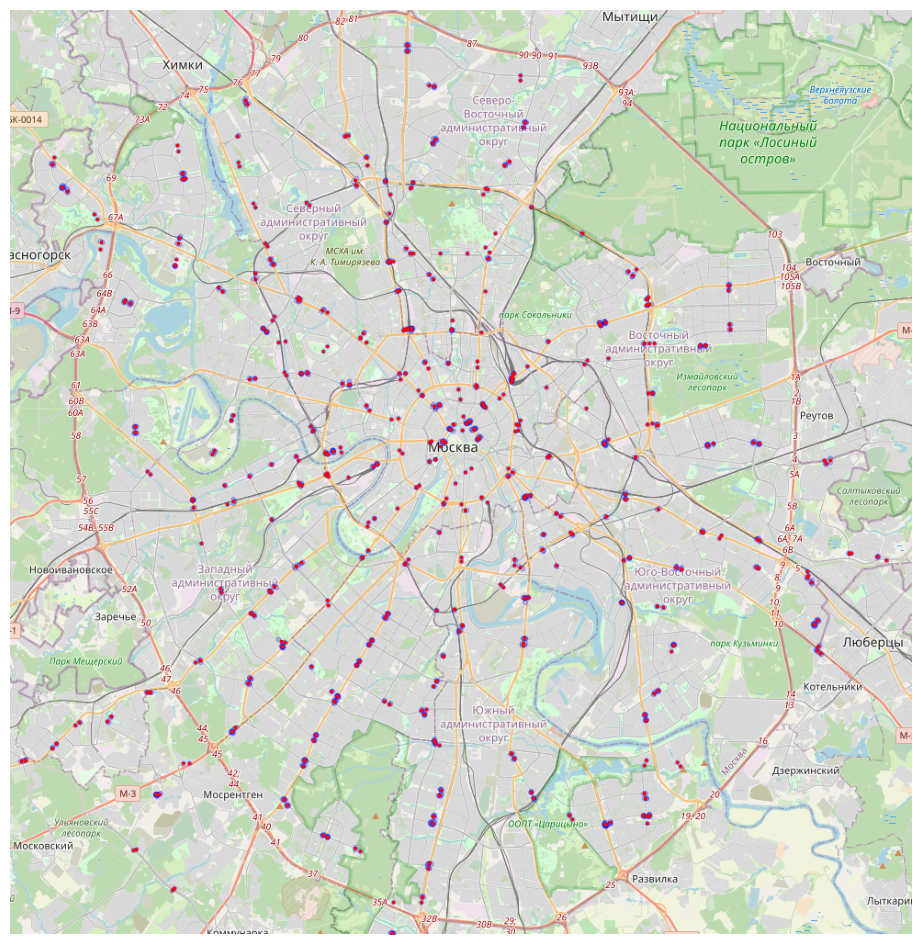

In [18]:
entrances_coords = helpers.calc_cartesian_coords(metro_final['Entrance_lat'], metro_final['Entrance_lon'])
stations_coords = helpers.calc_cartesian_coords(metro_final['Station_lat'], metro_final['Station_lon'])
clusters_coords = helpers.calc_cartesian_coords(metro_final['Cluster_lat'], metro_final['Cluster_lon'])

mos_img = plt.imread(os.path.join(PATH_TO_ROOT, 'data', 'images', 'map.png'))

bbox_geo = (37.3260, 37.9193, 55.5698, 55.9119)
bbox_cartes = helpers.calc_cartesian_coords(bbox_geo[2:], bbox_geo[:2])
bbox = bbox_cartes['x'].to_list() + bbox_cartes['y'].to_list()

fig, ax = plt.subplots(figsize=(12,12))
ax.scatter(entrances_coords['x'], entrances_coords['y'], zorder=1, alpha=0.2, c='b', s=10)
ax.scatter(clusters_coords['x'], clusters_coords['y'], zorder=1, alpha=1, c='r', s=2)

ax.set_xlim(bbox[0],bbox[1])
ax.set_ylim(bbox[2],bbox[3])
ax.axis('off')
ax.imshow(mos_img, zorder=0, extent=bbox, aspect='equal')
plt.show()

In [19]:
metro_final

,EntranceName,OnTerritoryOfMoscow,AdmArea,District,Entrance_lon,Entrance_lat,VestibuleType,Station,Line,EntranceNumber,StationIncomingPassengers,StationOutgoingPassengers,StationEntrancesCount,EntranceIncomingPassengers,EntranceOutgoingPassengers,Cluster,ClusterIncomingPassengers,ClusterOutgoingPassengers,Cluster_lon,Cluster_lat,Station_lon,Station_lat
0,"Китай-город, вход-выход 5 в северный вестибюль",да,Центральный административный округ,Басманный район,37.631677,55.757315,подземный,китай-город,калужско-рижская линия,5,4.611309e+06,4.762701e+06,14,329379,340192,"китай-город, калужско-рижская линия, группа вх...",2305653,2381344,37.630991,55.756901,37.632493,55.755193
1,"Китай-город, вход-выход 4 в северный вестибюль",да,Центральный административный округ,Тверской район,37.631205,55.756855,подземный,китай-город,калужско-рижская линия,4,4.611309e+06,4.762701e+06,14,329379,340192,"китай-город, калужско-рижская линия, группа вх...",2305653,2381344,37.630991,55.756901,37.632493,55.755193
2,"Китай-город, вход-выход 6 в северный вестибюль",да,Центральный административный округ,Басманный район,37.631951,55.757236,подземный,китай-город,калужско-рижская линия,6,4.611309e+06,4.762701e+06,14,329379,340192,"китай-город, калужско-рижская линия, группа вх...",2305653,2381344,37.630991,55.756901,37.632493,55.755193
3,"Китай-город, вход-выход 2 в северный вестибюль",да,Центральный административный округ,Тверской район,37.629468,55.756640,подземный,китай-город,калужско-рижская линия,2,4.611309e+06,4.762701e+06,14,329379,340192,"китай-город, калужско-рижская линия, группа вх...",2305653,2381344,37.630991,55.756901,37.632493,55.755193
4,"Китай-город, вход-выход 1 в северный вестибюль",да,Центральный административный округ,Тверской район,37.630006,55.756247,подземный,китай-город,калужско-рижская линия,1,4.611309e+06,4.762701e+06,14,329379,340192,"китай-город, калужско-рижская линия, группа вх...",2305653,2381344,37.630991,55.756901,37.632493,55.755193
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1042,"Новаторская, вход-выход 2 в вестибюль",да,Юго-Западный административный округ,Обручевский район,37.523728,55.668786,подземный,новаторская,большая кольцевая линия,2,6.556400e+05,6.531063e+05,2,327820,326553,"новаторская, большая кольцевая линия, группа в...",655640,653106,37.523902,55.668924,37.523902,55.668924
1043,"Каховская, вход-выход 11 в 1-й вестибюль",да,Юго-Западный административный округ,район Зюзино,37.599806,55.652986,подземный,каховская,большая кольцевая линия,11,8.104603e+05,8.328040e+05,4,202615,208201,"каховская, большая кольцевая линия, группа вхо...",202615,208201,37.599806,55.652986,37.597478,55.652745
1044,"Каховская, вход-выход 6 во 2-й вестибюль",да,Юго-Западный административный округ,район Зюзино,37.596570,55.652460,подземный,каховская,большая кольцевая линия,6,8.104603e+05,8.328040e+05,4,202615,208201,"каховская, большая кольцевая линия, группа вхо...",607845,624603,37.596702,55.652665,37.597478,55.652745
1045,"Каховская, вход-выход 7 во 2-й вестибюль",да,Юго-Западный административный округ,район Зюзино,37.596377,55.652930,подземный,каховская,большая кольцевая линия,7,8.104603e+05,8.328040e+05,4,202615,208201,"каховская, большая кольцевая линия, группа вхо...",607845,624603,37.596702,55.652665,37.597478,55.652745


In [20]:
common_cols = ['Line']
station_cols = common_cols + [col for col in metro_final.columns if 'Station' in col]
cluster_cols = common_cols + [col for col in metro_final.columns if 'Cluster' in col]
entrances_cols = common_cols + ['OnTerritoryOfMoscow', 'AdmArea', 'District'] + ['VestibuleType']\
    + [col for col in metro_final.columns if 'Entrance' in col and col != 'StationEntrancesCount']
metro_final['object_id_station'] = prepare_data.create_object_id(metro_final[station_cols])
metro_final['object_id_cluster'] = prepare_data.create_object_id(metro_final[cluster_cols])
metro_final['object_id_entrance'] = prepare_data.create_object_id(metro_final[entrances_cols])

100%|██████████| 1047/1047 [00:00<00:00, 142764.51it/s]


In [21]:
assert metro_final.duplicated().sum()==0

In [22]:
mandatory_metro_cols = [OBJECT_ID_METRO_COL] + [col for col in MANDATORY_COLS if col != OBJECT_ID_COL] + ['population']
print(mandatory_metro_cols)

['object_id_metro', 'adm_area', 'district', 'object_type', 'lat', 'lon', 'address', 'population']


In [23]:
metro_colmap = {
    'AdmArea': ADM_AREA_COL,
    'District': DISTRICT_COL,
    'EntranceName': ADDRESS_COL,
    'Station': ADDRESS_COL,
    'Cluster': ADDRESS_COL
}
metro_colmap.update({col: LATITUDE_COL for col in metro_final.columns if '_lat' in col})
metro_colmap.update({col: LONGITUDE_COL for col in metro_final.columns if '_lon' in col})
metro_colmap

{'AdmArea': 'adm_area',
 'District': 'district',
 'EntranceName': 'address',
 'Station': 'address',
 'Cluster': 'address',
 'Entrance_lat': 'lat',
 'Cluster_lat': 'lat',
 'Station_lat': 'lat',
 'Entrance_lon': 'lon',
 'Cluster_lon': 'lon',
 'Station_lon': 'lon'}

In [24]:
metro_stations = metro_final[station_cols].copy()
metro_stations[OBJECT_ID_METRO_COL] = metro_final['object_id_station']
metro_stations[OBJECT_TYPE_COL] = 'станция метро'
pass_columns = [col for col in metro_stations.columns if 'Passengers' in col]
assert len(pass_columns) == 2
metro_stations['population'] = (metro_stations[pass_columns].mean(axis=1) / 90).round(0).astype(int)

metro_stations = metro_stations.drop_duplicates()
assert metro_stations[['Station', 'Line']].duplicated().sum() == 0
assert metro_stations.duplicated(subset=OBJECT_ID_METRO_COL).sum()==0
metro_stations

,Line,Station,StationIncomingPassengers,StationOutgoingPassengers,StationEntrancesCount,Station_lon,Station_lat,object_id_metro,object_type,population
0,калужско-рижская линия,китай-город,4.611309e+06,4.762701e+06,14,37.632493,55.755193,cb102f6b9d341d9fdc1a4571088a7d91d29862167c76e8...,станция метро,52078
14,калужско-рижская линия,калужская,2.789995e+06,2.890080e+06,10,37.540167,55.656790,1c99788b270f0a957fed01e194ea9f9abab54a536109b2...,станция метро,31556
24,люблинско-дмитровская линия,братиславская,3.092889e+06,3.080851e+06,6,37.750832,55.659516,9355e0e2f696e3562ac04a1df34b786912ce2d00f75ba4...,станция метро,34299
30,бутовская линия легкого метро,бульвар адмирала ушакова,7.926297e+05,7.831418e+05,1,37.541645,55.545011,36d333776dfcb9d4b139584ba6183b2df25d0d7e6fde99...,станция метро,8754
31,серпуховско-тимирязевская линия,бульвар дмитрия донского,4.413484e+06,4.264049e+06,10,37.576555,55.569328,4647f51e2a77a555354ed313104a885d4911a4bb4b4689...,станция метро,48209
...,...,...,...,...,...,...,...,...,...,...
1032,большая кольцевая линия,зюзино,8.741387e+05,8.659490e+05,4,37.573924,55.655638,81b24f508c62e0f7ff5c2c107ba8a076f90e741c0d8742...,станция метро,9667
1036,большая кольцевая линия,давыдково,5.085503e+05,5.079143e+05,1,37.451973,55.714655,48b2f8c22e2ef593a7f85b14a71f387397ef170b55bda9...,станция метро,5647
1037,большая кольцевая линия,аминьевская,5.810790e+05,5.687090e+05,4,37.464723,55.697117,cdf23e177ca9fe3d1c5a08ca95151d1aff694154f5fd4c...,станция метро,6388
1041,большая кольцевая линия,новаторская,6.556400e+05,6.531063e+05,2,37.523902,55.668924,0e09a9960a5297baeb9a3587fd268544b7804b629c3dcb...,станция метро,7271


In [25]:
metro_stations.loc[metro_stations[['Station', 'Line']].duplicated(keep=False), station_cols].sort_values(by='Station')

,Line,Station,StationIncomingPassengers,StationOutgoingPassengers,StationEntrancesCount,Station_lon,Station_lat


In [26]:
metro_entrances = metro_final[entrances_cols].copy()
metro_entrances[OBJECT_ID_METRO_COL] = metro_final['object_id_entrance']
metro_entrances[OBJECT_TYPE_COL] = 'вход в метро'
pass_columns = [col for col in metro_entrances.columns if 'Passengers' in col]
assert len(pass_columns) == 2
metro_entrances['population'] = (metro_entrances[pass_columns].mean(axis=1) / 90).round(0).astype(int)

metro_entrances = metro_entrances.drop_duplicates()
assert metro_entrances[['EntranceName']].duplicated().sum() == 0
assert metro_entrances.duplicated(subset=OBJECT_ID_METRO_COL).sum()==0
metro_entrances

,Line,OnTerritoryOfMoscow,AdmArea,District,VestibuleType,EntranceName,Entrance_lon,Entrance_lat,EntranceNumber,EntranceIncomingPassengers,EntranceOutgoingPassengers,object_id_metro,object_type,population
0,калужско-рижская линия,да,Центральный административный округ,Басманный район,подземный,"Китай-город, вход-выход 5 в северный вестибюль",37.631677,55.757315,5,329379,340192,6c91b2d8ec9695751818ce0fbbf13b7a2945af3cd6ffa2...,вход в метро,3720
1,калужско-рижская линия,да,Центральный административный округ,Тверской район,подземный,"Китай-город, вход-выход 4 в северный вестибюль",37.631205,55.756855,4,329379,340192,27967adc5c27ebcea83afdaa1ae358f31cafa9055b9736...,вход в метро,3720
2,калужско-рижская линия,да,Центральный административный округ,Басманный район,подземный,"Китай-город, вход-выход 6 в северный вестибюль",37.631951,55.757236,6,329379,340192,aef73378c503d4b38f5116cb645e696a4dca225583e11f...,вход в метро,3720
3,калужско-рижская линия,да,Центральный административный округ,Тверской район,подземный,"Китай-город, вход-выход 2 в северный вестибюль",37.629468,55.756640,2,329379,340192,895f048aeab520acca33c618ea2b86e9696a32a825242d...,вход в метро,3720
4,калужско-рижская линия,да,Центральный административный округ,Тверской район,подземный,"Китай-город, вход-выход 1 в северный вестибюль",37.630006,55.756247,1,329379,340192,c6143642ec658f1106e71688b7bef92bbcaa118e77ae2e...,вход в метро,3720
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1042,большая кольцевая линия,да,Юго-Западный административный округ,Обручевский район,подземный,"Новаторская, вход-выход 2 в вестибюль",37.523728,55.668786,2,327820,326553,182e0af9aaeb42356db22673b2f50c8aac8cf31294afbd...,вход в метро,3635
1043,большая кольцевая линия,да,Юго-Западный административный округ,район Зюзино,подземный,"Каховская, вход-выход 11 в 1-й вестибюль",37.599806,55.652986,11,202615,208201,a44477f342da5bc01889d767391d468bbf9e08dcc97fcb...,вход в метро,2282
1044,большая кольцевая линия,да,Юго-Западный административный округ,район Зюзино,подземный,"Каховская, вход-выход 6 во 2-й вестибюль",37.596570,55.652460,6,202615,208201,308dbc558de42da260e68f0bb62c28d83fdd23e1f711ce...,вход в метро,2282
1045,большая кольцевая линия,да,Юго-Западный административный округ,район Зюзино,подземный,"Каховская, вход-выход 7 во 2-й вестибюль",37.596377,55.652930,7,202615,208201,3ecb0e5afbe5bdfaad6c1291060155f0779cc040ec12c2...,вход в метро,2282


In [27]:
metro_clusters = metro_final[cluster_cols].copy()
metro_clusters[OBJECT_ID_METRO_COL] = metro_final['object_id_cluster']
metro_clusters[OBJECT_TYPE_COL] = 'кластер входов в метро'
pass_columns = [col for col in metro_clusters.columns if 'Passengers' in col]
assert len(pass_columns) == 2
metro_clusters['population'] = (metro_clusters[pass_columns].mean(axis=1) / 90).round(0).astype(int)

metro_clusters = metro_clusters.drop_duplicates()
assert metro_clusters[['Cluster', 'Line']].duplicated().sum() == 0
assert metro_clusters.duplicated(subset=OBJECT_ID_METRO_COL).sum()==0
metro_clusters

,Line,Cluster,ClusterIncomingPassengers,ClusterOutgoingPassengers,Cluster_lon,Cluster_lat,object_id_metro,object_type,population
0,калужско-рижская линия,"китай-город, калужско-рижская линия, группа вх...",2305653,2381344,37.630991,55.756901,6543c748d61462f58b98d8e0e06ad4f1998df04d8a20e4...,кластер входов в метро,26039
7,калужско-рижская линия,"китай-город, калужско-рижская линия, группа вх...",1317516,1360768,37.633364,55.753103,b01a6891ecde218be8d286d9b8ce976d3bf35d53e772b7...,кластер входов в метро,14879
11,калужско-рижская линия,"китай-город, калужско-рижская линия, группа вх...",988137,1020576,37.634836,55.753992,c12992b218532a27cd4542408002c23144405e38586d69...,кластер входов в метро,11160
14,калужско-рижская линия,"калужская, калужско-рижская линия, группа вход...",1673994,1734042,37.539406,55.656063,69b04e702cedec414e6bfdd95f64b6e894f98340c0f453...,кластер входов в метро,18934
20,калужско-рижская линия,"калужская, калужско-рижская линия, группа вход...",1115996,1156028,37.541308,55.657879,6839be98d82d1ffde2c62c61a2a6d862fe430c6410fbc0...,кластер входов в метро,12622
...,...,...,...,...,...,...,...,...,...
1037,большая кольцевая линия,"аминьевская, большая кольцевая линия, группа в...",290538,284354,37.464958,55.696448,1dac31515f9c6e414f4b79437915031b55bcd49d9c9dd0...,кластер входов в метро,3194
1039,большая кольцевая линия,"аминьевская, большая кольцевая линия, группа в...",290538,284354,37.464488,55.697787,a748cc1d1b3be196ab66196a13a28c26f3144cdeea5662...,кластер входов в метро,3194
1041,большая кольцевая линия,"новаторская, большая кольцевая линия, группа в...",655640,653106,37.523902,55.668924,a45b8247358f227a7304aa50630ca2a1f656be1e3bad16...,кластер входов в метро,7271
1043,большая кольцевая линия,"каховская, большая кольцевая линия, группа вхо...",202615,208201,37.599806,55.652986,c1f9067188b852765f53b838e2bec564e5ab8931e2d2b3...,кластер входов в метро,2282


In [28]:
metro_clusters[metro_clusters[['Cluster', 'Line']].duplicated(keep=False)].sort_values(by='Cluster')

,Line,Cluster,ClusterIncomingPassengers,ClusterOutgoingPassengers,Cluster_lon,Cluster_lat,object_id_metro,object_type,population


In [29]:
with open(CONFIG_PATH, mode='r') as db_file:
    db_config = json.load(db_file)

database = DB(db_config)
database.load_to_bd(metro_final, RAW_METRO_NAME)

In [30]:
metro_clusters = metro_clusters.rename(columns=metro_colmap)
metro_clusters.columns = [col.replace('Cluster', '')\
    .replace('Incoming', 'Incoming_')\
        .replace('Outgoing', 'Outgoing_').lower() for col in metro_clusters.columns]

metro_entrances = metro_entrances.rename(columns=metro_colmap)
metro_entrances.columns = [col.replace('Entrance', '')\
    .replace('Incoming', 'Incoming_')\
        .replace('Outgoing', 'Outgoing_').lower() for col in metro_entrances.columns]

metro_stations = metro_stations.rename(columns=metro_colmap)
metro_stations.columns = [col.replace('Station', '')\
    .replace('Incoming', 'Incoming_')\
        .replace('Outgoing', 'Outgoing_').lower() for col in metro_stations.columns]

In [31]:
metro_stations[ADDRESS_COL] = metro_stations[ADDRESS_COL].replace({'арбатская (арбатско-покровская линия)': 'арбатская'})
metro_stations[ADDRESS_COL] += ' (' + metro_stations['line'] + ')'
metro_stations[ADDRESS_COL] = metro_stations[ADDRESS_COL]
display(metro_stations.head())
display(metro_clusters.head())
display(metro_entrances.head())

,line,address,incoming_passengers,outgoing_passengers,entrancescount,lon,lat,object_id_metro,object_type,population
0,калужско-рижская линия,китай-город (калужско-рижская линия),4.611309e+06,4.762701e+06,14,37.632493,55.755193,cb102f6b9d341d9fdc1a4571088a7d91d29862167c76e8...,станция метро,52078
14,калужско-рижская линия,калужская (калужско-рижская линия),2.789995e+06,2.890080e+06,10,37.540167,55.656790,1c99788b270f0a957fed01e194ea9f9abab54a536109b2...,станция метро,31556
24,люблинско-дмитровская линия,братиславская (люблинско-дмитровская линия),3.092889e+06,3.080851e+06,6,37.750832,55.659516,9355e0e2f696e3562ac04a1df34b786912ce2d00f75ba4...,станция метро,34299
30,бутовская линия легкого метро,бульвар адмирала ушакова (бутовская линия легк...,7.926297e+05,7.831418e+05,1,37.541645,55.545011,36d333776dfcb9d4b139584ba6183b2df25d0d7e6fde99...,станция метро,8754
31,серпуховско-тимирязевская линия,бульвар дмитрия донского (серпуховско-тимирязе...,4.413484e+06,4.264049e+06,10,37.576555,55.569328,4647f51e2a77a555354ed313104a885d4911a4bb4b4689...,станция метро,48209


,line,address,incoming_passengers,outgoing_passengers,lon,lat,object_id_metro,object_type,population
0,калужско-рижская линия,"китай-город, калужско-рижская линия, группа вх...",2305653,2381344,37.630991,55.756901,6543c748d61462f58b98d8e0e06ad4f1998df04d8a20e4...,кластер входов в метро,26039
7,калужско-рижская линия,"китай-город, калужско-рижская линия, группа вх...",1317516,1360768,37.633364,55.753103,b01a6891ecde218be8d286d9b8ce976d3bf35d53e772b7...,кластер входов в метро,14879
11,калужско-рижская линия,"китай-город, калужско-рижская линия, группа вх...",988137,1020576,37.634836,55.753992,c12992b218532a27cd4542408002c23144405e38586d69...,кластер входов в метро,11160
14,калужско-рижская линия,"калужская, калужско-рижская линия, группа вход...",1673994,1734042,37.539406,55.656063,69b04e702cedec414e6bfdd95f64b6e894f98340c0f453...,кластер входов в метро,18934
20,калужско-рижская линия,"калужская, калужско-рижская линия, группа вход...",1115996,1156028,37.541308,55.657879,6839be98d82d1ffde2c62c61a2a6d862fe430c6410fbc0...,кластер входов в метро,12622


,line,onterritoryofmoscow,adm_area,district,vestibuletype,address,lon,lat,number,incoming_passengers,outgoing_passengers,object_id_metro,object_type,population
0,калужско-рижская линия,да,Центральный административный округ,Басманный район,подземный,"Китай-город, вход-выход 5 в северный вестибюль",37.631677,55.757315,5,329379,340192,6c91b2d8ec9695751818ce0fbbf13b7a2945af3cd6ffa2...,вход в метро,3720
1,калужско-рижская линия,да,Центральный административный округ,Тверской район,подземный,"Китай-город, вход-выход 4 в северный вестибюль",37.631205,55.756855,4,329379,340192,27967adc5c27ebcea83afdaa1ae358f31cafa9055b9736...,вход в метро,3720
2,калужско-рижская линия,да,Центральный административный округ,Басманный район,подземный,"Китай-город, вход-выход 6 в северный вестибюль",37.631951,55.757236,6,329379,340192,aef73378c503d4b38f5116cb645e696a4dca225583e11f...,вход в метро,3720
3,калужско-рижская линия,да,Центральный административный округ,Тверской район,подземный,"Китай-город, вход-выход 2 в северный вестибюль",37.629468,55.756640,2,329379,340192,895f048aeab520acca33c618ea2b86e9696a32a825242d...,вход в метро,3720
4,калужско-рижская линия,да,Центральный административный округ,Тверской район,подземный,"Китай-город, вход-выход 1 в северный вестибюль",37.630006,55.756247,1,329379,340192,c6143642ec658f1106e71688b7bef92bbcaa118e77ae2e...,вход в метро,3720


In [32]:
all_metro_objects = pd.concat([metro_stations, metro_clusters, metro_entrances])
all_metro_objects = all_metro_objects[mandatory_metro_cols].fillna('-')
all_metro_objects

,object_id_metro,adm_area,district,object_type,lat,lon,address,population
0,cb102f6b9d341d9fdc1a4571088a7d91d29862167c76e8...,-,-,станция метро,55.755193,37.632493,китай-город (калужско-рижская линия),52078
14,1c99788b270f0a957fed01e194ea9f9abab54a536109b2...,-,-,станция метро,55.656790,37.540167,калужская (калужско-рижская линия),31556
24,9355e0e2f696e3562ac04a1df34b786912ce2d00f75ba4...,-,-,станция метро,55.659516,37.750832,братиславская (люблинско-дмитровская линия),34299
30,36d333776dfcb9d4b139584ba6183b2df25d0d7e6fde99...,-,-,станция метро,55.545011,37.541645,бульвар адмирала ушакова (бутовская линия легк...,8754
31,4647f51e2a77a555354ed313104a885d4911a4bb4b4689...,-,-,станция метро,55.569328,37.576555,бульвар дмитрия донского (серпуховско-тимирязе...,48209
...,...,...,...,...,...,...,...,...
1042,182e0af9aaeb42356db22673b2f50c8aac8cf31294afbd...,Юго-Западный административный округ,Обручевский район,вход в метро,55.668786,37.523728,"Новаторская, вход-выход 2 в вестибюль",3635
1043,a44477f342da5bc01889d767391d468bbf9e08dcc97fcb...,Юго-Западный административный округ,район Зюзино,вход в метро,55.652986,37.599806,"Каховская, вход-выход 11 в 1-й вестибюль",2282
1044,308dbc558de42da260e68f0bb62c28d83fdd23e1f711ce...,Юго-Западный административный округ,район Зюзино,вход в метро,55.652460,37.596570,"Каховская, вход-выход 6 во 2-й вестибюль",2282
1045,3ecb0e5afbe5bdfaad6c1291060155f0779cc040ec12c2...,Юго-Западный административный округ,район Зюзино,вход в метро,55.652930,37.596377,"Каховская, вход-выход 7 во 2-й вестибюль",2282


In [33]:
print(mandatory_metro_cols)

['object_id_metro', 'adm_area', 'district', 'object_type', 'lat', 'lon', 'address', 'population']


In [34]:
database.load_to_bd(all_metro_objects, ALL_METRO_NAME)